In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f

import torchvision
import torchvision.transforms as t
from torch.utils.data import DataLoader

from torchsummary import summary

import copy

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = t.Compose([t.ToTensor(), t.RandomHorizontalFlip(p=0.5), t.Normalize(0.5, 0.5)])

In [4]:
train_set = torchvision.datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
dev_test = torchvision.datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

In [5]:
dev_set, test_set = torch.utils.data.random_split(dev_test, [0.6, 0.4])

In [6]:
label_categories = train_set.classes

In [7]:
print("Train: ", len(train_set))
print("Validation: ", len(dev_set))
print("Test: ", len(test_set))

Train:  60000
Validation:  6000
Test:  4000


In [8]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_set, batch_size=len(dev_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))

In [9]:
x, y = next(iter(train_loader))
print("Train: Image", x.size(), "and Length", len(train_loader), "Label", y.size())
x, y = next(iter(dev_loader))
print("Val: Image", x.size(), "and Length", len(dev_loader), "Label", y.size())
x, y = next(iter(test_loader))
print("Test: Image", x.size(), "and Length", len(test_loader), "Label", y.size())

Train: Image torch.Size([32, 1, 28, 28]) and Length 1875 Label torch.Size([32])
Val: Image torch.Size([6000, 1, 28, 28]) and Length 1 Label torch.Size([6000])
Test: Image torch.Size([4000, 1, 28, 28]) and Length 1 Label torch.Size([4000])


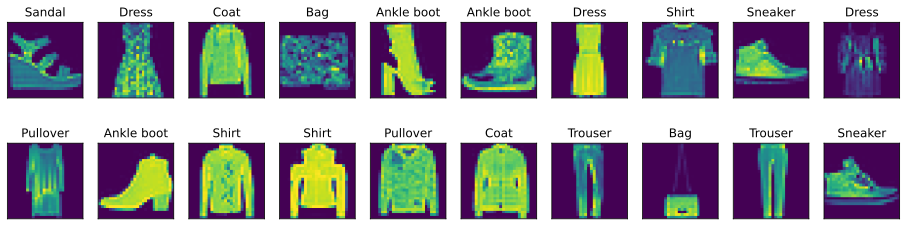

In [10]:
_, axis = plt.subplots(2, 10, figsize=(16, 4))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(x.size()[0])

    img = np.squeeze(x[pic, :, :, :])
    label = label_categories[y[pic]]

    ax.imshow(img)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [11]:
def ae_model():
    
    class AutoEncoder(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.enc_conv1 = nn.Conv2d(1, 16, 3, 2, 1)
            # (28 + 2*1 - 3)/2 + 1 = 14
            
            self.enc_conv2 = nn.Conv2d(16, 32, 3, 2, 1)
            # (14 + 2*1 - 3)/2 + 1 = 7
            
            self.dec_conv1 = nn.ConvTranspose2d(32, 16, 4, 2, 1)
            # (28 + 2*1 - 3)/2 + 1 = 14
            
            self.dec_conv2 = nn.ConvTranspose2d(16, 1, 4, 2, 1)
            # (14 + 2*1 - 3)/2 = 7
        
        def forward(self, x):
            x = self.enc_conv1(x)
            x = f.leaky_relu(x)
            
            x = self.enc_conv2(x)
            x = f.leaky_relu(x)
            
            x = self.dec_conv1(x)
            x = f.leaky_relu(x)
            
            x = self.dec_conv2(x)
            x = f.leaky_relu(x)
            
            return x
    
    autoencoder = AutoEncoder()
    
    loss_fun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    
    return autoencoder, loss_fun, optimizer

In [12]:
summary(ae_model()[0], (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2             [-1, 32, 7, 7]           4,640
   ConvTranspose2d-3           [-1, 16, 14, 14]           8,208
   ConvTranspose2d-4            [-1, 1, 28, 28]             257
Total params: 13,265
Trainable params: 13,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.05
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


In [13]:
def ae_train_model():
    
    num_epochs = 5

    autoencoder, loss_fun, optimizer = ae_model()
    autoencoder.to(device)
    
    train_loss = []
    dev_loss = []
    
    for epoch in range(num_epochs):
        
        autoencoder.train()
        batch_loss = []
        
        for x, y in train_loader:
            x = x.to(device)
            
            y_hat = autoencoder(x)
            loss = loss_fun(y_hat, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
        
        train_loss.append(np.mean(batch_loss))
        
        autoencoder.eval()

        x, y = next(iter(test_loader))
        x = x.to(device)
        
        with torch.no_grad():
            y_hat = autoencoder(x)
            loss = loss_fun(y_hat, x)
            
        dev_loss.append(loss.item())

    del x, y, y_hat, loss
    torch.cuda.empty_cache()
    
    return train_loss, dev_loss, autoencoder

In [14]:
train_loss, dev_loss, autoencoder = ae_train_model()

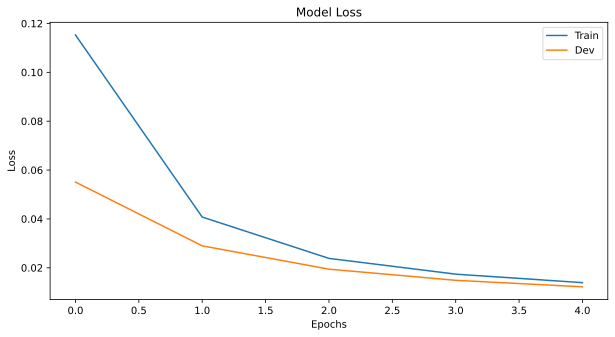

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, "-", label="Train")
plt.plot(dev_loss, "-", label="Dev")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend();

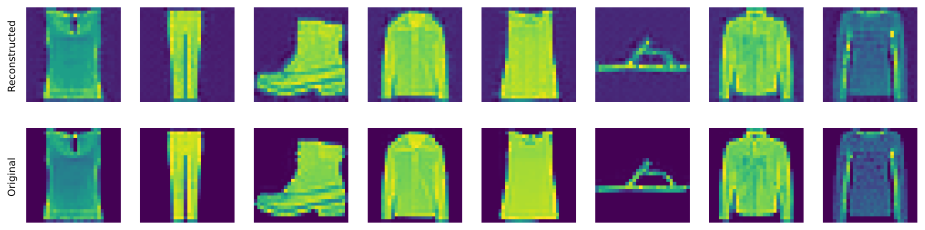

In [16]:
x, y = next(iter(test_loader))

autoencoder.cpu()
autoencoder.eval()

y_hat = autoencoder(x)
torch.cuda.empty_cache()

_, axis = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    pic = y_hat[i, 0, :, :].detach()
    pic = pic/2 + 0.5
    axis[0, i].imshow(pic)
    axis[0, i].axis("off")

    pic = x[i, 0, :, :].detach()
    pic = pic/2 + 0.5
    axis[1, i].imshow(pic)
    axis[1, i].axis("off")
    
    if i == 0:
        axis[0, 0].text(-6, 14, "Reconstructed", rotation=90, va="center")
        axis[1, 0].text(-6, 14, "Original", rotation=90, va="center")

plt.show()

In [17]:
def cnn_model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()

            self.enc_conv1 = nn.Conv2d(1, 16, 3, 2, 1)
            # (28 + 2*1 - 3)/2 + 1 = 14

            self.enc_conv2 = nn.Conv2d(16, 32, 3, 2, 1)
            # (14 + 2*1 - 3)/2 + 1 = 7
            
            self.fc1 = nn.Linear(7*7*32, 50)
            
            self.fc2 = nn.Linear(50, 10)
        
        def forward(self, x):
            x = self.enc_conv1(x)
            x = f.leaky_relu(x)
            
            x = self.enc_conv2(x)
            x = f.leaky_relu(x)
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            
            x = self.fc1(x)
            x = f.leaky_relu(x)
            
            x = self.fc2(x)
            x = f.leaky_relu(x)
            
            return x
        
    cnn = CNN()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
    
    return cnn, loss_fun, optimizer

In [18]:
summary(cnn_model()[0], (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2             [-1, 32, 7, 7]           4,640
            Linear-3                   [-1, 50]          78,450
            Linear-4                   [-1, 10]             510
Total params: 83,760
Trainable params: 83,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.32
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


In [19]:
def cnn_train_model(cnn, loss_fun, optimizer):

    num_epochs = 5

    cnn.to(device)

    train_loss = []
    train_acc = []
    dev_loss = []
    dev_acc = []

    for epoch in range(num_epochs):

        cnn.train()
        batch_loss = []
        batch_acc = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))

        cnn.eval()

        x, y = next(iter(dev_loader))
        
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)

        dev_loss.append(loss.item())
        dev_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
    
    del x, y, y_hat, loss
    torch.cuda.empty_cache()

    return train_acc, train_loss, dev_acc, dev_loss, cnn

In [20]:
cnn, loss_fun, optimizer = cnn_model()
train_acc, train_loss, dev_acc, dev_loss, cnn = cnn_train_model(cnn, loss_fun, optimizer )

In [21]:
x, y = next(iter(test_loader))

cnn.cpu()
cnn.eval()

with torch.no_grad():
    y_hat = cnn(x)
    loss = loss_fun(y_hat, y).item()
    
acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

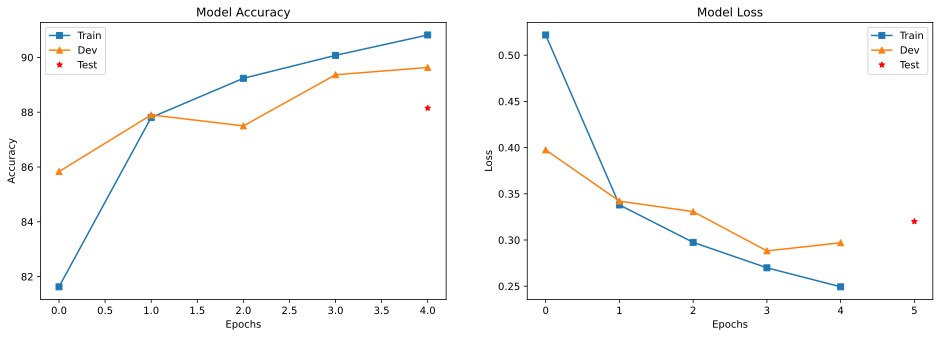

In [22]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_acc, "s-", label="Train")
axis[0].plot(dev_acc, "^-", label="Dev")
axis[0].plot(len(dev_acc)-1, acc, "r*", label="Test")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy")
axis[0].set_title("Model Accuracy")
axis[0].legend()

axis[1].plot(train_loss, "s-", label="Train")
axis[1].plot(dev_loss, "^-", label="Dev")
axis[1].plot(len(dev_loss), loss, "r*", label="Test")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss")
axis[1].set_title("Model Loss")
axis[1].legend();

In [23]:
pre_trained_model, loss_fun, optimizer = cnn_model()

for target, source in zip(pre_trained_model.named_parameters(), autoencoder.named_parameters()):
    if "enc" in target[0]:
        print(f"Pretrain: {target[0]} <-- AutoEnc: {source[0]}")
        target[1].data = copy.deepcopy(source[1].data)

Pretrain: enc_conv1.weight <-- AutoEnc: enc_conv1.weight
Pretrain: enc_conv1.bias <-- AutoEnc: enc_conv1.bias
Pretrain: enc_conv2.weight <-- AutoEnc: enc_conv2.weight
Pretrain: enc_conv2.bias <-- AutoEnc: enc_conv2.bias


In [24]:
train_acc, train_loss, dev_acc, dev_loss, post_cnn = cnn_train_model(pre_trained_model, loss_fun, optimizer)

In [25]:
x, y = next(iter(test_loader))

post_cnn.cpu()
post_cnn.eval()

with torch.no_grad():
    y_hat = post_cnn(x)

loss = loss_fun(y_hat, y).item()    
acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

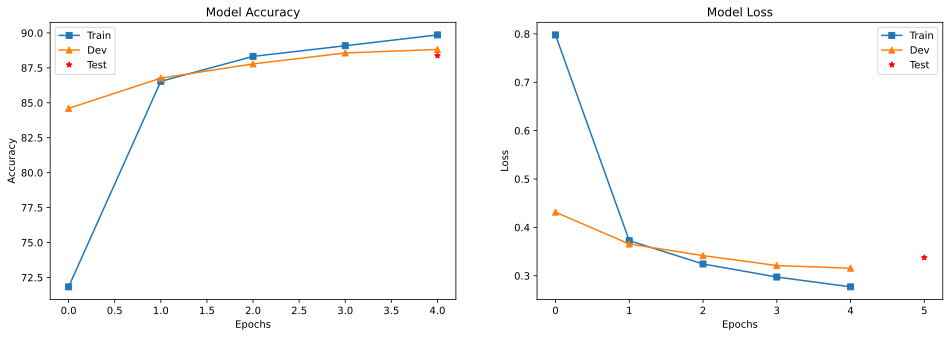

In [26]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_acc, "s-", label="Train")
axis[0].plot(dev_acc, "^-", label="Dev")
axis[0].plot(len(dev_acc)-1, acc, "r*", label="Test")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy")
axis[0].set_title("Model Accuracy")
axis[0].legend()

axis[1].plot(train_loss, "s-", label="Train")
axis[1].plot(dev_loss, "^-", label="Dev")
axis[1].plot(len(dev_loss), loss, "r*", label="Test")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss")
axis[1].set_title("Model Loss")
axis[1].legend();